In [1]:
%matplotlib inline
import matplotlib.pyplot as plot
from IPython import display
from IPython.core.pylabtools import figsize
from __future__ import print_function

import os
import sys
import glob
import time
import numpy as np
import numpy.random as nr

from keras.preprocessing.image import load_img, img_to_array, array_to_img

from keras.models import Model
from keras.applications import vgg16

from scipy.misc import imsave
from scipy.optimize import fmin_l_bfgs_b

np.set_printoptions(precision=3, linewidth=120, suppress=True)

Using TensorFlow backend.


In [2]:
sys.path.append('../src')
from my_keras_utilities import get_available_gpus
import keras.backend as K
K.set_floatx('float32')

print('Backend:        {}'.format(K.backend()))
print('Data format:    {}'.format(K.image_data_format()))
print('Available GPUS:', get_available_gpus())

Backend:        tensorflow
Data format:    channels_last
Available GPUS: ['/gpu:0']


In [102]:
figdir = '../figures/style_transfer/'
resdir = figdir + 'results/'
os.makedirs(resdir, exist_ok=True)
image_file_path = figdir + 'museu_by_bruna.png'
style_file_path = figdir + 'tolouse-lautrec.png'

width, height = load_img(image_file_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg16.preprocess_input(img)
    return img

def deprocess_image(a):
    x = a.copy()
    x = x.reshape(img_nrows, img_ncols, 3)
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

print('Shape of the images: {} rows, {} columns'.format(img_nrows, img_ncols))

Shape of the images: 400 rows, 499 columns


(1, 400, 499, 3) -123.68 151.061


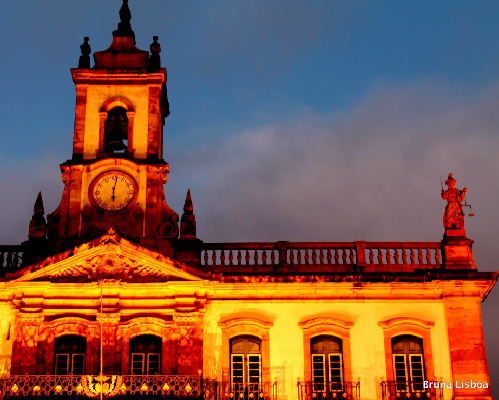

In [90]:
vgg_image = preprocess_image(image_file_path)
vgg_style = preprocess_image(style_file_path)

print(vgg_image.shape, vgg_image.min(), vgg_image.max())

array_to_img(deprocess_image(vgg_image[0]))

In [122]:
from keras.applications.vgg16 import VGG16
# from vgg16_avg import VGG16_Avg as VGG16

vgg = VGG16(include_top=False, weights='imagenet', input_shape=vgg_image.shape[1:])
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 400, 499, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 400, 499, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 400, 499, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 200, 249, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 200, 249, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 200, 249, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 100, 124, 128)     0         
__________

In [123]:
layer = vgg.get_layer('block5_conv1').output

layer_model = Model(vgg.input, layer)
targ = K.variable(layer_model.predict(vgg_image))

print(vgg_image.shape, vgg_image.min(), vgg_image.max())


(1, 400, 499, 3) 0.0 255.0


In [124]:
loss = K.mean(K.square(layer - targ))
grads = K.gradients(loss, vgg.input)
fn = K.function([vgg.input], [loss] + grads)

In [136]:
x = np.random.uniform(-2.5, 2.5, vgg_image.shape)
x.shape

(1, 400, 499, 3)

In [137]:
class Evaluator(object):
    def __init__(self, fun, shp): 
        self.funct = fun
        self.shape = shp
        
    def get_loss(self, x):
        loss, self.grad_values = self.funct([x.reshape(self.shape)])
        return loss.astype(np.float64)

    def get_grads(self, x): 
        return self.grad_values.flatten().astype(np.float64)

In [138]:
def my_solver(obj, niter, x):
    images = []
    try:
        for i in range(niter):
            x, min_val, info = fmin_l_bfgs_b(obj.get_loss, x.flatten(), fprime=obj.get_grads, maxfun=20)
            x = np.clip(x, -127, 127)
            print('{:2d}. loss: {:.3f}'.format(i, min_val))    
            images.append(x.copy())
    except KeyboardInterrupt:
        print('Interrupted!!')
    finally:
        return images

In [141]:
A = my_solver(Evaluator(fn, vgg_image.shape), 20, x)

 0. loss: 1526.417
 1. loss: 689.908
 2. loss: 445.125
 3. loss: 340.743
 4. loss: 280.373
 5. loss: 238.727
 6. loss: 210.744
 7. loss: 188.845
 8. loss: 172.666
 9. loss: 159.708
10. loss: 149.111
11. loss: 139.978
12. loss: 132.601
13. loss: 126.620
14. loss: 121.339
15. loss: 116.838
16. loss: 113.085
17. loss: 109.380
18. loss: 106.120
19. loss: 103.175


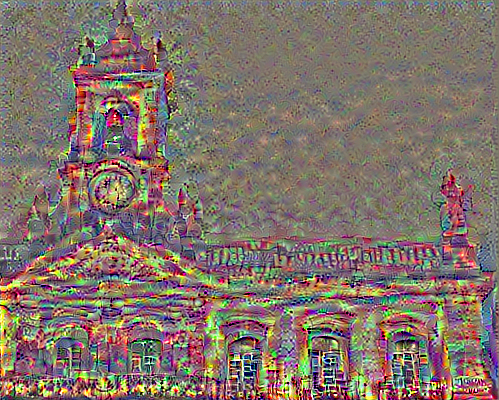

In [142]:
array_to_img(deprocess_image(A[-1]))

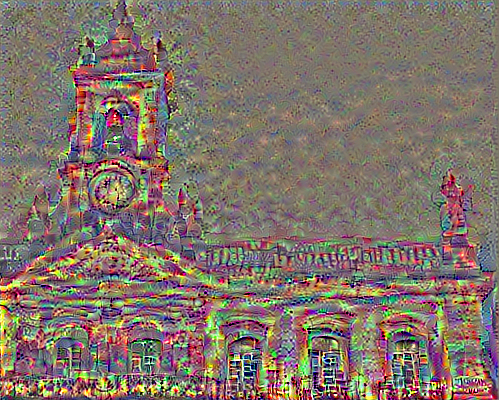

In [143]:
array_to_img(deprocess_image(A[-5]))